# Отток клиентов

Из Банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [ ]:
from imblearn.over_sampling import SMOTE


# !pip install imblearn# импортируем нужные библиотеки и методы

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, precision_score,recall_score, fbeta_score,roc_auc_score
from collections import Counter
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from category_encoders.binary import BinaryEncoder
from pandas_profiling import ProfileReport
from sklearn.metrics import plot_roc_curve,plot_confusion_matrix
import optuna
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE


In [ ]:
# задаем ГПЧ
np.random.seed(7)

In [ ]:
# !pip3 install category-encoders
# !pip3 install pandas_profiling
# !pip3 install --upgrade --user scikit-learn
# !pip3 install optuna
# !pip install imblearn

In [ ]:
# скрываем предупреждения
warnings.filterwarnings('ignore')

In [ ]:

df = pd.read_csv(r'/datasets/Churn.csv')


In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
# удаляем колонку индексации
df.drop(columns='RowNumber',axis=1,inplace=True)

In [ ]:
# проверка
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
#  убираем из таблицы ненужные столбцы
#  которые никак не повлияют на качество модели
# и создаем новую таблицу для дальнейших
# действий
clf_data = df.drop(columns=['CustomerId','Surname',],axis=1)

In [ ]:
# проверка
clf_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
# создаем отчет для таблицы
# ProfileReport(clf_data,title='Отчет таблицы Бета-Банка ')


In [ ]:
# смотрим на столбец с географией
clf_data['Geography']

0        France
1         Spain
2        France
3        France
4         Spain
         ...   
9995     France
9996     France
9997     France
9998    Germany
9999     France
Name: Geography, Length: 10000, dtype: object

In [ ]:
# создаем бинарный кодировщик
bn = BinaryEncoder()

In [ ]:
#
bn.fit_transform(clf_data['Geography'])

,Geography_0,Geography_1
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0
...,...,...
9995,0,1
9996,0,1
9997,0,1
9998,1,1


In [ ]:
#  для проверки
clf_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [ ]:
# изменение категориальных переменных
clf_data['Gender'] = np.where(clf_data['Gender'] == 'Female',0,1)
# удаялем Geography за ненадобносттю
clf_data = clf_data.join(bn.fit_transform(clf_data['Geography'])).drop(columns='Geography',axis=1)



In [ ]:
# проверка
clf_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_0,Geography_1
0,619,0,42,2.0,0.00,1,1,1,101348.88,1,0,1
1,608,0,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,0,42,8.0,159660.80,3,1,0,113931.57,1,0,1
3,699,0,39,1.0,0.00,2,0,0,93826.63,0,0,1
4,850,0,43,2.0,125510.82,1,1,1,79084.10,0,1,0


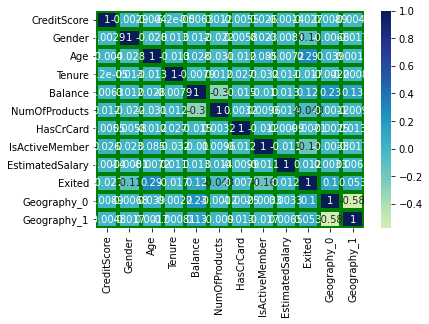

In [ ]:
# отображаем температурную карту корреляцию
sns.heatmap(clf_data.corr(),annot=True,cmap="YlGnBu",center=0,linewidth=3,linecolor='green')
plt.show()

In [ ]:
# таблица корреляции
clf_data.corr()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_0,Geography_1
CreditScore,1.000000,-0.002857,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.008928,-0.004780
Gender,-0.002857,1.000000,-0.027544,0.012634,0.012087,-0.021859,0.005766,0.022544,-0.008112,-0.106512,-0.006772,-0.016889
Age,-0.003965,-0.027544,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.039208,0.001685
Tenure,-0.000062,0.012634,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761,-0.002167,-0.000810
Balance,0.006268,0.012087,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.231329,0.134892
NumOfProducts,0.012238,-0.021859,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.001230,-0.009039
HasCrCard,-0.005458,0.005766,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,-0.002467,0.013480
IsActiveMember,0.025651,0.022544,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.003317,-0.016732
EstimatedSalary,-0.001384,-0.008112,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.003332,0.006482
Exited,-0.027094,-0.106512,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.104955,0.052667


## Исследование задачи

### Борьба с дисбалансом классов. С удалением NaN

#### Используем стратификацию и вес классов.

In [ ]:
# фиксация random_state
rs=7

In [ ]:
# разбиваем две таблицы для
# дальнейших манипуляций
clf_data_dropna = clf_data.copy().dropna()
clf_data_fillna = clf_data.copy()

In [ ]:
# отбираем признаки зависимые и независимые
features = clf_data_dropna.drop(columns=['Exited'],axis=1)
target = clf_data_dropna['Exited']
# разбиваем со стратификацией выборки на
# тренировочную и валидационную и тестовую
features_train,features_tv,target_train,target_tv = train_test_split(features,target,test_size=0.4,stratify=target,random_state=rs)
features_test,features_valid,target_test,target_valid = train_test_split(features_tv,target_tv,test_size=0.5,stratify=target_tv,random_state=rs)



In [ ]:
# для тестовой и валидационной выборках лучшей модели
def metrics_check(target_valid,predict_valid):
    print(f'Accuracy для валидационной выборки: {accuracy_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Balanced accuracy для валидационной выборки: {balanced_accuracy_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'F1-score для валидационной выборки: {f1_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Precision score для валидационной выборки: {precision_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Recall score для валидационной выборки: {recall_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'F-beta score для валидационной выборки: {fbeta_score(target_valid,predict_valid,beta=1)}')
    print('-'*100)

In [ ]:
# функция для сокращения количество доминирующего класса
def downsample(features, target, fraction):
    np.random.seed(7)
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled




In [ ]:
# функция для увеличения второго, дефицитного класса
def upsample(features, target, repeat):
    np.random.seed(7)
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled)

    return features_upsampled, target_upsampled



In [ ]:
tenure_group_tmp = df.groupby('Tenure').agg({'Exited':['count','sum']}).reset_index()


In [ ]:
tenure_group_tmp.columns = ['tenure','total_count','leave_count']

In [ ]:
from math import trunc

In [ ]:
tenure_group_tmp['percent'] = (tenure_group_tmp['leave_count'] / tenure_group_tmp['total_count']) * 100

In [ ]:
tenure_group_tmp

,tenure,total_count,leave_count,percent
0,0.0,382,90,23.560209
1,1.0,952,213,22.373950
2,2.0,950,185,19.473684
3,3.0,928,198,21.336207
4,4.0,885,184,20.790960
5,5.0,927,187,20.172600
6,6.0,881,177,20.090806
7,7.0,925,160,17.297297
8,8.0,933,174,18.649518
9,9.0,882,194,21.995465


**Вывод:**

Корреляция между `Tenure` и количеством уходов - `Exited` имеет унарный минус, который говорит о том, что с увеличением срока лояльности клиента процент уходов клиента уменьшается. Корреляция в 0.3 по модулю говорит о несильной, нижесреднего корреляции, но все равно она есть. Таким образом заполнение `0` пропусков будет не очень хорошей идеей.

In [ ]:
tmp_tenure = df['Tenure'].copy()

In [ ]:
tmp_tenure

0        2.0
1        1.0
2        8.0
3        1.0
4        2.0
        ... 
9995     5.0
9996    10.0
9997     7.0
9998     3.0
9999     NaN
Name: Tenure, Length: 10000, dtype: float64

In [ ]:
tmp_tenure.isna().sum()

909

<AxesSubplot:>

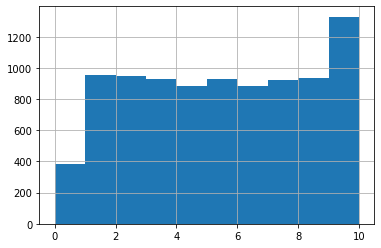

In [ ]:
tmp_tenure.hist()

In [ ]:
tmp_tenure.fillna(value=0,inplace=True)

<AxesSubplot:>

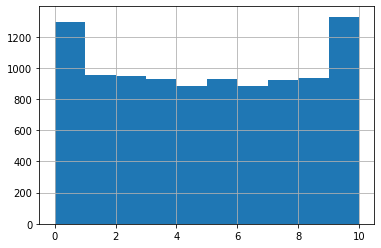

In [ ]:
tmp_tenure.hist()

In [ ]:
# находим дисбаланс классов
len(target_train[target_train == 0]) / len(target_train[target_train == 1])

3.9046762589928057

In [ ]:
# задаем вес
class_weight = {0:1, 1:3.9}

In [ ]:
#  с помощью библиотеки optuna
#  подберем лучшие гиперпараметры
# максимизируя F1-score
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,15)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight=class_weight,random_state=rs)
    clf_obj.fit(features_train,target_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
# ищем гиперпараметры
np.random.seed(7)
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:16:59,903] A new study created in memory with name: no-name-754985ae-3268-4c75-bec5-f5e4862088ff
[I 2022-09-10 14:17:00,320] Trial 0 finished with value: 0.5652173913043478 and parameters: {'classifier': 'RandomForest', 'max_depth': 5, 'n_estimators': 92, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5652173913043478.
[I 2022-09-10 14:17:00,415] Trial 1 finished with value: 0.5673758865248227 and parameters: {'classifier': 'RandomForest', 'max_depth': 5, 'n_estimators': 21, 'criterion': 'gini'}. Best is trial 1 with value: 0.5673758865248227.
[I 2022-09-10 14:17:00,520] Trial 2 finished with value: 0.5843621399176955 and parameters: {'classifier': 'RandomForest', 'max_depth': 9, 'n_estimators': 17, 'criterion': 'gini'}. Best is trial 2 with value: 0.5843621399176955.
[I 2022-09-10 14:17:00,681] Trial 3 finished with value: 0.5843230403800475 and parameters: {'classifier': 'RandomForest', 'max_depth': 6, 'n_estimators': 31, 'criterion': 'entropy'}. Best is tria

FrozenTrial(number=141, values=[0.6048780487804877], datetime_start=datetime.datetime(2022, 9, 10, 14, 18, 22, 762171), datetime_complete=datetime.datetime(2022, 9, 10, 14, 18, 23, 461508), params={'classifier': 'RandomForest', 'max_depth': 7, 'n_estimators': 136, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=15, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=141, state=TrialState.COMPLETE, value=None)


**Вывод:**

Нашли __лучший__ набор гиперпараметров для выборок со стратификацией и весами классов:

Best is trial 46 with value: 0.6455542021924483.
params={'classifier': 'RandomForest', 'max_depth': 8, 'n_estimators': 143, 'criterion': 'gini'}    


In [ ]:
%%time

# обучаем и смотрим на метрику F1
model3 = RandomForestClassifier(criterion='gini',n_estimators = 143,max_depth=8,class_weight=class_weight,random_state=rs)
model3.fit(features_train,target_train)
predicted_valid_model3 = model3.predict(features_test)
print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')


Значение F1 на валидационной выборке равна 0.5984848484848485
Значение F1 на валидационной выборке равна 0.6083650190114067
CPU times: user 852 ms, sys: 2 µs, total: 852 ms
Wall time: 858 ms


In [ ]:
roc_auc_score(target_valid,model3.predict_proba(features_valid)[:,1])


0.8409517356405712

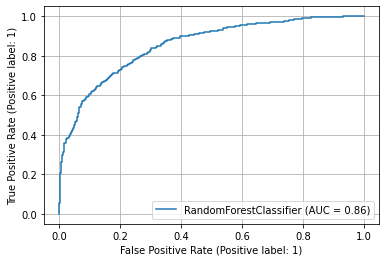

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

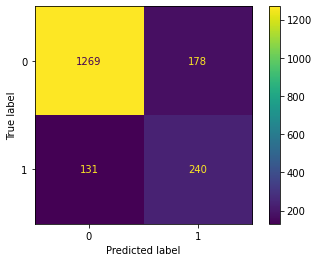

In [ ]:
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:

metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.83003300330033
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.7619435694633566
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.6083650190114067
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.5741626794258373
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.6469002695417789
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.6083650190114067
----------------------------------------------------------------------------------------------------


In [ ]:
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1447
           1       0.57      0.65      0.61       371

    accuracy                           0.83      1818
   macro avg       0.74      0.76      0.75      1818
weighted avg       0.84      0.83      0.83      1818



In [ ]:
# создаем таблицу с важностью каждого признака
feature_importance = pd.DataFrame(model3.feature_importances_,
                                 index=features.columns,
                                 columns=['importance']).reset_index()





In [ ]:
# переименовываем столбцы
feature_importance.columns=['features','importance']

In [ ]:
# смотрим, что получилось
feature_importance


,features,importance
0,CreditScore,0.062017
1,Gender,0.027967
2,Age,0.369395
3,Tenure,0.036927
4,Balance,0.093814
5,NumOfProducts,0.217878
6,HasCrCard,0.008204
7,IsActiveMember,0.072872
8,EstimatedSalary,0.064930
9,Geography_0,0.027138


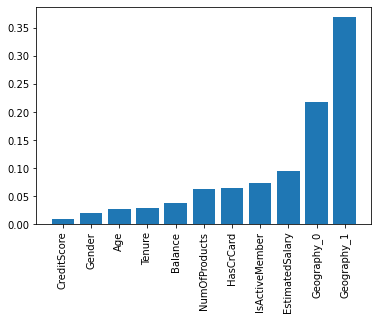

In [ ]:
# отображем ввиде графика
plt.bar(x=feature_importance['features'],height=sorted(feature_importance['importance']))
plt.xticks(rotation=90)
plt.show()

**Вывод:**

Считаю, что лучше оставить все признаки для того, чтобы модель не потеряла свое качество.

#### Используем стратификацию без весов

In [ ]:
# отбираем признаки зависимые и независимые
features = clf_data_dropna.drop(columns=['Exited'],axis=1)
target = clf_data_dropna['Exited']
# разбиваем со стратификацией выборки на
# тренировочную и валидационную и тестовую
features_train,features_tv,target_train,target_tv = train_test_split(features,target,test_size=0.4,stratify=target,random_state=rs)
features_test,features_valid,target_test,target_valid = train_test_split(features_tv,target_tv,test_size=0.5,stratify=target_tv,random_state=rs)




In [ ]:


#  с помощью библиотеки optuna
#  подберем лучшие гиперпараметры
# максимизируя F1-score
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,15)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,random_state=rs)
    clf_obj.fit(features_train,target_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:19:08,069] A new study created in memory with name: no-name-cb80688d-2ef9-4b2d-bca4-62f234166e9d
[I 2022-09-10 14:19:09,225] Trial 0 finished with value: 0.5391304347826087 and parameters: {'classifier': 'RandomForest', 'max_depth': 14, 'n_estimators': 150, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5391304347826087.
[I 2022-09-10 14:19:09,613] Trial 1 finished with value: 0.4483430799220274 and parameters: {'classifier': 'RandomForest', 'max_depth': 5, 'n_estimators': 92, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5391304347826087.
[I 2022-09-10 14:19:09,675] Trial 2 finished with value: 0.5063291139240507 and parameters: {'classifier': 'RandomForest', 'max_depth': 7, 'n_estimators': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.5391304347826087.
[I 2022-09-10 14:19:10,265] Trial 3 finished with value: 0.5246478873239436 and parameters: {'classifier': 'RandomForest', 'max_depth': 12, 'n_estimators': 82, 'criterion': 'entropy'}. Best i

FrozenTrial(number=111, values=[0.5555555555555557], datetime_start=datetime.datetime(2022, 9, 10, 14, 20, 0, 76173), datetime_complete=datetime.datetime(2022, 9, 10, 14, 20, 0, 740961), params={'classifier': 'RandomForest', 'max_depth': 11, 'n_estimators': 94, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=15, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=111, state=TrialState.COMPLETE, value=None)


In [ ]:
%%time

# обучаем и смотрим на метрику F1
model3 = RandomForestClassifier(criterion='gini',n_estimators = 21,max_depth=14,class_weight=class_weight,random_state=rs)
model3.fit(features_downsampled_train,target_downsampled_train)
predicted_valid_model3 = model3.predict(features_test)

print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')


NameError: name 'features_downsampled_train' is not defined

#### Используем вес классов без стратификации

In [ ]:
# отбираем признаки зависимые и независимые
features = clf_data_dropna.drop(columns=['Exited'],axis=1)
target = clf_data_dropna['Exited']
# разбиваем со стратификацией выборки на
# тренировочную и валидационную и тестовую
features_train,features_tv,target_train,target_tv = train_test_split(features,target,test_size=0.4,random_state=rs)
features_test,features_valid,target_test,target_valid = train_test_split(features_tv,target_tv,test_size=0.5,random_state=rs)



In [ ]:


#  с помощью библиотеки optuna
#  подберем лучшие гиперпараметры
# максимизируя F1-score
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,15)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight=class_weight,random_state=rs)
    clf_obj.fit(features_train,target_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
# находим дисбаланс классов
len(target_train[target_train == 0]) / len(target_train[target_train == 1])

3.9179440937781784

In [ ]:
# задаем вес
class_weight = {0:1, 1:3.9}

In [ ]:
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:20:57,936] A new study created in memory with name: no-name-289c6afa-bc1c-4438-9c6a-f68348c0de8e
[I 2022-09-10 14:20:58,432] Trial 0 finished with value: 0.5985185185185186 and parameters: {'classifier': 'RandomForest', 'max_depth': 12, 'n_estimators': 79, 'criterion': 'gini'}. Best is trial 0 with value: 0.5985185185185186.
[I 2022-09-10 14:20:59,494] Trial 1 finished with value: 0.5950155763239876 and parameters: {'classifier': 'RandomForest', 'max_depth': 14, 'n_estimators': 143, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5985185185185186.
[I 2022-09-10 14:20:59,740] Trial 2 finished with value: 0.5907692307692307 and parameters: {'classifier': 'RandomForest', 'max_depth': 13, 'n_estimators': 38, 'criterion': 'gini'}. Best is trial 0 with value: 0.5985185185185186.
[I 2022-09-10 14:21:00,145] Trial 3 finished with value: 0.5949926362297496 and parameters: {'classifier': 'RandomForest', 'max_depth': 12, 'n_estimators': 62, 'criterion': 'gini'}. Best is tr

FrozenTrial(number=27, values=[0.6382460414129111], datetime_start=datetime.datetime(2022, 9, 10, 14, 21, 12, 690358), datetime_complete=datetime.datetime(2022, 9, 10, 14, 21, 13, 222707), params={'classifier': 'RandomForest', 'max_depth': 8, 'n_estimators': 108, 'criterion': 'gini'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=15, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=27, state=TrialState.COMPLETE, value=None)


In [ ]:
%%time

# обучаем и смотрим на метрику F1
model3 = RandomForestClassifier(n_estimators = 75,max_depth=8,class_weight=class_weight,random_state=rs)
model3.fit(features_downsampled_train,target_downsampled_train)
predicted_valid_model3 = model3.predict(features_test)

print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')


NameError: name 'features_downsampled_train' is not defined

#### Используем стратификацию вес классов и уменьшение записей основного класса

In [ ]:
# отбираем признаки зависимые и независимые
features = clf_data_dropna.drop(columns=['Exited'],axis=1)
target = clf_data_dropna['Exited']
# разбиваем со стратификацией выборки на
# тренировочную и валидационную и тестовую
features_train,features_tv,target_train,target_tv = train_test_split(features,target,test_size=0.4,stratify=target,random_state=rs)
features_test,features_valid,target_test,target_valid = train_test_split(features_tv,target_tv,test_size=0.5,stratify=target_tv,random_state=rs)



In [ ]:
# задаем признаки и цель
#  с обрезанием
np.random.seed(7)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.6)

In [ ]:
# задаем признаки и цель
#  тренировочные и тестовую
np.random.seed(7)
features_downsampled_train,features_downsampled_valid,target_downsampled_train,target_downsampled_valid = train_test_split(features_downsampled,target_downsampled,test_size=0.25,stratify=target_downsampled)


In [ ]:
# смотрим на результат
features_downsampled_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_0,Geography_1
7289,627,0,35,7.0,0.00,1,1,0,187718.26,1,0
1092,715,1,41,4.0,94267.90,1,0,1,152821.12,0,1
4070,676,1,48,1.0,131659.59,2,0,1,14152.15,1,0
2486,683,0,36,7.0,0.00,2,1,0,104786.59,1,0
6257,774,1,36,9.0,130809.77,1,1,0,152290.28,1,1


In [ ]:

len(target_downsampled_valid[target_downsampled_valid==0])



652

In [ ]:
len(target_downsampled_valid[target_downsampled_valid==1])

278

In [ ]:
# дисбаланс классов
len(target_downsampled_valid[target_downsampled_valid==0]) / len(target_downsampled_valid[target_downsampled_valid==1])


2.3453237410071943

In [ ]:
# задаем весы
class_weight = {0:1, 1:2.3}

In [ ]:
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,20)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight=class_weight,random_state=rs)
    clf_obj.fit(features_downsampled_train,target_downsampled_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:22:45,147] A new study created in memory with name: no-name-6b203f40-e092-4dbe-8425-12793c9965d8
[I 2022-09-10 14:22:45,448] Trial 0 finished with value: 0.5798816568047338 and parameters: {'classifier': 'RandomForest', 'max_depth': 6, 'n_estimators': 85, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5798816568047338.
[I 2022-09-10 14:22:45,732] Trial 1 finished with value: 0.5727272727272728 and parameters: {'classifier': 'RandomForest', 'max_depth': 19, 'n_estimators': 60, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5798816568047338.
[I 2022-09-10 14:22:45,966] Trial 2 finished with value: 0.5869565217391304 and parameters: {'classifier': 'RandomForest', 'max_depth': 7, 'n_estimators': 70, 'criterion': 'gini'}. Best is trial 2 with value: 0.5869565217391304.
[I 2022-09-10 14:22:46,650] Trial 3 finished with value: 0.5829596412556054 and parameters: {'classifier': 'RandomForest', 'max_depth': 20, 'n_estimators': 137, 'criterion': 'entropy'}. Best i

FrozenTrial(number=64, values=[0.6161879895561357], datetime_start=datetime.datetime(2022, 9, 10, 14, 23, 1, 690050), datetime_complete=datetime.datetime(2022, 9, 10, 14, 23, 1, 897363), params={'classifier': 'RandomForest', 'max_depth': 9, 'n_estimators': 50, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=64, state=TrialState.COMPLETE, value=None)


**Вывод:**

Нашли __лучший__ набор гиперпараметров для выборок со стратификацией, весами классов и уменьшением записей основного класса:

Best is trial 67 with value: 0.6330049261083743.

params={'classifier': 'RandomForest', 'max_depth': 9, 'n_estimators': 115, 'criterion': 'gini'}

In [ ]:
%%time

# обучаем и смотрим на метрику F1
model3 = RandomForestClassifier(criterion='gini',n_estimators = 115,max_depth=9,class_weight=class_weight,random_state=rs)
model3.fit(features_downsampled_train,target_downsampled_train)
predicted_valid_model3 = model3.predict(features_test)

print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')


Значение F1 на валидационной выборке равна 0.600262123197903
Значение F1 на валидационной выборке равна 0.609597924773022
CPU times: user 460 ms, sys: 7.99 ms, total: 468 ms
Wall time: 475 ms


In [ ]:
roc_auc_score(target_test,model3.predict_proba(features_test)[:,1])


0.8547007750956063

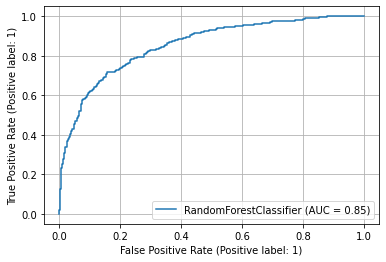

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

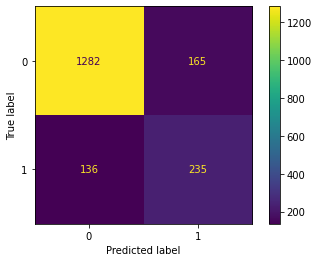

In [ ]:
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:

metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.8344334433443344
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.7596970775114233
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.609597924773022
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.5875
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.633423180592992
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.609597924773022
----------------------------------------------------------------------------------------------------


In [ ]:
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1447
           1       0.59      0.63      0.61       371

    accuracy                           0.83      1818
   macro avg       0.75      0.76      0.75      1818
weighted avg       0.84      0.83      0.84      1818



#### Используем стратификацию вес классов и увеличение записей второстепенного класса

In [ ]:
# задаем признаки и цель с дублированием записей
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)



In [ ]:
len(target_upsampled[target_upsampled==1])

3336

In [ ]:
len(target_upsampled[target_upsampled==0])

4342

In [ ]:
# проверяем дисбаланс
len(target_upsampled[target_upsampled==0])/ len(target_upsampled[target_upsampled==1])

1.3015587529976018

In [ ]:
# задаем вес
class_weight = {0:1, 1:1.3}

In [ ]:
# разбиваем на треиноровочные и тестовые выборки
np.random.seed(7)

features_upsampled_train,features_upsampled_valid,target_upsampled_train,target_upsampled_valid = train_test_split(features_upsampled,target_upsampled,test_size=0.25,stratify=target_upsampled)


In [ ]:
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,20)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight=class_weight,random_state=rs)
    clf_obj.fit(features_upsampled_train,target_upsampled_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
np.random.seed(7)
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:23:32,083] A new study created in memory with name: no-name-a426367e-c169-4ab2-8b1a-7f5c96eee57e
[I 2022-09-10 14:23:32,465] Trial 0 finished with value: 0.5896510228640193 and parameters: {'classifier': 'RandomForest', 'max_depth': 8, 'n_estimators': 75, 'criterion': 'gini'}. Best is trial 0 with value: 0.5896510228640193.
[I 2022-09-10 14:23:32,733] Trial 1 finished with value: 0.5772357723577235 and parameters: {'classifier': 'RandomForest', 'max_depth': 14, 'n_estimators': 35, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5896510228640193.
[I 2022-09-10 14:23:32,837] Trial 2 finished with value: 0.5687203791469194 and parameters: {'classifier': 'RandomForest', 'max_depth': 7, 'n_estimators': 19, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5896510228640193.
[I 2022-09-10 14:23:32,917] Trial 3 finished with value: 0.5486211901306242 and parameters: {'classifier': 'RandomForest', 'max_depth': 20, 'n_estimators': 10, 'criterion': 'gini'}. Best is tr

FrozenTrial(number=66, values=[0.5982028241335045], datetime_start=datetime.datetime(2022, 9, 10, 14, 24, 20, 627127), datetime_complete=datetime.datetime(2022, 9, 10, 14, 24, 21, 570657), params={'classifier': 'RandomForest', 'max_depth': 11, 'n_estimators': 139, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=66, state=TrialState.COMPLETE, value=None)


**Вывод:**

Нашли __лучший__ набор гиперпараметров для выборок со стратификацией, весами классов и "размножением" второстепенного класса:

Best is trial 25 with value: 0.6378896882494005.
params={'classifier': 'RandomForest', 'max_depth': 10, 'n_estimators': 88, 'criterion': 'entropy'}

In [ ]:
%%time
# обучаем и смотрим на метрику F1
model3 = RandomForestClassifier(n_estimators = 88,max_depth=10,criterion='entropy',class_weight=class_weight,random_state=rs)
model3.fit(features_upsampled_train,target_upsampled_train)
predicted_valid_model3 = model3.predict(features_test)
print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')



Значение F1 на валидационной выборке равна 0.5848822800495662
Значение F1 на валидационной выборке равна 0.605830164765526
CPU times: user 643 ms, sys: 4.01 ms, total: 647 ms
Wall time: 661 ms


In [ ]:
roc_auc_score(target_test,model3.predict_proba(features_test)[:,1])


0.8550099937224894

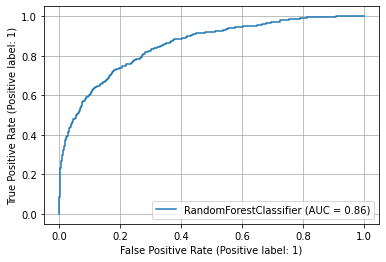

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

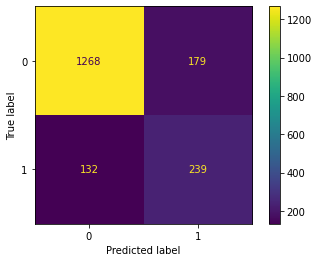

In [ ]:
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:

metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.828932893289329
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.7602503180667503
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.605830164765526
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.5717703349282297
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.6442048517520216
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.605830164765526
----------------------------------------------------------------------------------------------------


In [ ]:
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1447
           1       0.57      0.64      0.61       371

    accuracy                           0.83      1818
   macro avg       0.74      0.76      0.75      1818
weighted avg       0.84      0.83      0.83      1818



#### Используем стратификацию вес классов SMOTE

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(target_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(target_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE()
features_train_smote, target_train_smote = sm.fit_resample(features_train, target_train)
print('After OverSampling, the shape of train_X: {}'.format(features_train_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(target_train_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(target_train_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(target_train_smote == 0)))


Before OverSampling, counts of label '1': 1112
Before OverSampling, counts of label '0': 4342 

After OverSampling, the shape of train_X: (8684, 11)
After OverSampling, the shape of train_y: (8684,) 

After OverSampling, counts of label '1': 4342
After OverSampling, counts of label '0': 4342


In [ ]:
features_train_smote.shape

(8684, 11)

In [ ]:
features.shape

(9091, 11)

In [ ]:
target_train_smote.shape

(8684,)

In [ ]:
# првоерка
len(target_train_smote[target_train_smote==0])/ len(target_train_smote[target_train_smote==1])

1.0

In [ ]:
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,20)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight='balanced',random_state=rs)
    clf_obj.fit(features_train_smote,target_train_smote)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:26:25,988] A new study created in memory with name: no-name-8b569152-78a1-4d5a-bfd5-9bbf0c130577
[I 2022-09-10 14:26:26,784] Trial 0 finished with value: 0.5654993514915694 and parameters: {'classifier': 'RandomForest', 'max_depth': 18, 'n_estimators': 58, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5654993514915694.
[I 2022-09-10 14:26:27,928] Trial 1 finished with value: 0.5517241379310345 and parameters: {'classifier': 'RandomForest', 'max_depth': 8, 'n_estimators': 146, 'criterion': 'gini'}. Best is trial 0 with value: 0.5654993514915694.
[I 2022-09-10 14:26:28,044] Trial 2 finished with value: 0.5308056872037914 and parameters: {'classifier': 'RandomForest', 'max_depth': 6, 'n_estimators': 14, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5654993514915694.
[I 2022-09-10 14:26:28,124] Trial 3 finished with value: 0.5218417945690672 and parameters: {'classifier': 'RandomForest', 'max_depth': 8, 'n_estimators': 10, 'criterion': 'gini'}. Best is tr

FrozenTrial(number=98, values=[0.5755208333333333], datetime_start=datetime.datetime(2022, 9, 10, 14, 28, 26, 31183), datetime_complete=datetime.datetime(2022, 9, 10, 14, 28, 27, 495169), params={'classifier': 'RandomForest', 'max_depth': 19, 'n_estimators': 111, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=98, state=TrialState.COMPLETE, value=None)


**Вывод:**

Нашли __лучший__ набор гиперпараметров для выборок со SMOTE:

Best is trial 100 with value: 0.5848563968668407.
params={'classifier': 'RandomForest', 'max_depth': 16, 'n_estimators': 130, 'criterion': 'entropy'}

In [ ]:
%%time

# обучаем и смотрим на метрику F1
model3 = RandomForestClassifier(n_estimators = 130,max_depth=16,criterion='gini',class_weight=class_weight,random_state=rs)
model3.fit(features_train_smote,target_train_smote)
predicted_valid_model3 = model3.predict(features_test)
print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')


Значение F1 на валидационной выборке равна 0.5494223363286265
Значение F1 на валидационной выборке равна 0.5647668393782384
CPU times: user 1.54 s, sys: 3.99 ms, total: 1.54 s
Wall time: 1.57 s


In [ ]:
roc_auc_score(target_test,model3.predict_proba(features_test)[:,1])


0.8308015282106114

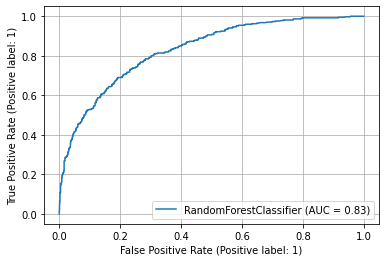

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

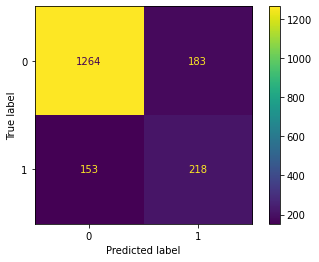

In [ ]:
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:

metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.8151815181518152
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.7305662612673866
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.5647668393782384
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.543640897755611
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.5876010781671159
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.5647668393782384
----------------------------------------------------------------------------------------------------


In [ ]:
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1447
           1       0.54      0.59      0.56       371

    accuracy                           0.82      1818
   macro avg       0.72      0.73      0.72      1818
weighted avg       0.82      0.82      0.82      1818



## Борьба с дисбалансом классов. С заполнением NaN

In [ ]:
# временная таблица для замены пропущенных значений
tmp_to_fill_na = clf_data_fillna.groupby('Age').agg({'Tenure':'median'}).reset_index()

In [ ]:
# для проверки
clf_data_fillna['Tenure'].isna().sum()

909

In [ ]:
# функция для преобразования серии к словарю
def to_dict(data,key,value):
    tmp_dct = {}
    for i in range(data.shape[0]):
        tmp_dct[data[key]object[i]] =  data[value][i]
    return tmp_dct

In [ ]:
# применяем функцию
tmp_to_fill_dct = to_dict(tmp_to_fill_na,'Age','Tenure')

In [ ]:
# что получилось
tmp_to_fill_dct

{18: 4.5,
 19: 5.0,
 20: 4.0,
 21: 4.0,
 22: 6.0,
 23: 5.0,
 24: 5.0,
 25: 5.0,
 26: 5.0,
 27: 5.0,
 28: 5.0,
 29: 5.0,
 30: 5.0,
 31: 5.0,
 32: 5.0,
 33: 5.0,
 34: 5.0,
 35: 5.0,
 36: 5.0,
 37: 5.0,
 38: 5.0,
 39: 5.0,
 40: 5.0,
 41: 5.0,
 42: 5.0,
 43: 5.0,
 44: 5.0,
 45: 5.0,
 46: 5.0,
 47: 5.0,
 48: 5.0,
 49: 5.0,
 50: 5.0,
 51: 4.0,
 52: 5.0,
 53: 5.0,
 54: 4.0,
 55: 6.5,
 56: 5.0,
 57: 5.0,
 58: 4.0,
 59: 5.0,
 60: 6.0,
 61: 4.0,
 62: 5.0,
 63: 5.0,
 64: 3.0,
 65: 4.5,
 66: 6.0,
 67: 5.0,
 68: 4.0,
 69: 5.0,
 70: 5.0,
 71: 4.0,
 72: 5.0,
 73: 6.0,
 74: 5.0,
 75: 3.0,
 76: 7.0,
 77: 6.0,
 78: 3.0,
 79: 6.0,
 80: 4.0,
 81: 5.5,
 82: 2.0,
 83: 6.0,
 84: 8.0,
 85: 10.0,
 88: 10.0,
 92: 1.0}

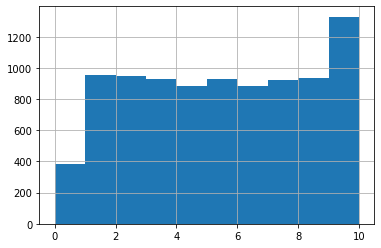

In [ ]:
# строим гистограму до
clf_data_fillna['Tenure'].hist()
plt.show()

In [ ]:
# поскольку np.nan != np.nan = 1
# то заменим на константу и
# далее заменим через цикл

clf_data_fillna.fillna(value=-1.0,inplace=True)

In [ ]:
# приводим к int
clf_data_fillna['Tenure'] = clf_data_fillna['Tenure'].astype('int')

In [ ]:
# замена значений через цикл
for i in range(len(clf_data_fillna['Tenure'])):
    if clf_data_fillna['Tenure'][i] == -1:
        key = clf_data_fillna['Age'][i]
        clf_data_fillna['Tenure'][i] = tmp_to_fill_dct[key]

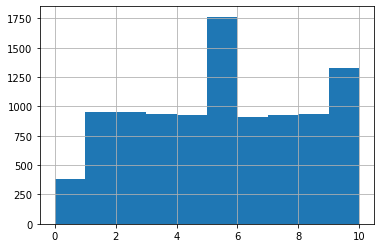

In [ ]:
# строим гистограму после
clf_data_fillna['Tenure'].hist()
plt.show()

**Вывод:**

Заметим, что распределение частот изменилось, появилась новая мода - но это нестрашно. НА качество модели это повлияет положительно.

#### Используем стратификацию и вес классов.

In [ ]:
clf_data_dropna['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

In [ ]:
# смотрим как изменились уникальные значения
# после оставления пропущенных значений
clf_data_fillna['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
# находим дисбаланс классов
len(target_train[target_train == 0]) / len(target_train[target_train == 1])

3.9046762589928057

In [ ]:
# задаем вес
class_weight = {0:1, 1:3.9}

In [ ]:
#  с помощью библиотеки optuna
#  подберем лучшие гиперпараметры
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,15)
        n_estimators = trial.suggest_int('n_estimators',5,100)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight=class_weight,random_state=rs)
    clf_obj.fit(features_train,target_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
np.random.seed(7)
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:31:16,547] A new study created in memory with name: no-name-541e01dc-00cc-4008-96e0-c7ace6aeb29f
[I 2022-09-10 14:31:17,014] Trial 0 finished with value: 0.6045918367346939 and parameters: {'classifier': 'RandomForest', 'max_depth': 8, 'n_estimators': 88, 'criterion': 'gini'}. Best is trial 0 with value: 0.6045918367346939.
[I 2022-09-10 14:31:17,297] Trial 1 finished with value: 0.5904522613065327 and parameters: {'classifier': 'RandomForest', 'max_depth': 8, 'n_estimators': 46, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6045918367346939.
[I 2022-09-10 14:31:17,371] Trial 2 finished with value: 0.5507584597432905 and parameters: {'classifier': 'RandomForest', 'max_depth': 5, 'n_estimators': 14, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6045918367346939.
[I 2022-09-10 14:31:17,720] Trial 3 finished with value: 0.5973254086181278 and parameters: {'classifier': 'RandomForest', 'max_depth': 11, 'n_estimators': 56, 'criterion': 'gini'}. Best is tri

FrozenTrial(number=25, values=[0.6061349693251533], datetime_start=datetime.datetime(2022, 9, 10, 14, 31, 26, 50302), datetime_complete=datetime.datetime(2022, 9, 10, 14, 31, 26, 483583), params={'classifier': 'RandomForest', 'max_depth': 7, 'n_estimators': 88, 'criterion': 'gini'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=15, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=100, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=25, state=TrialState.COMPLETE, value=None)


**Вывод:**

Нашли __лучший__ набор гиперпараметров для выборок со стратификацией:

Best is trial 109 with value: 0.6455542021924483.
params={'classifier': 'RandomForest', 'max_depth': 8, 'n_estimators': 143, 'criterion': 'gini'}

In [ ]:
# тестируем модель
model3 = RandomForestClassifier(criterion='gini',n_estimators = 143,max_depth=8,class_weight=class_weight,random_state=rs)
model3.fit(features_train,target_train)
predicted_valid_model3 = model3.predict(features_test)
print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')

Значение F1 на валидационной выборке равна 0.5984848484848485
Значение F1 на валидационной выборке равна 0.6083650190114067


In [ ]:
# значения площади под кривой ROC
roc_auc_score(target_test,model3.predict_proba(features_test)[:,1])


0.8551292105424925

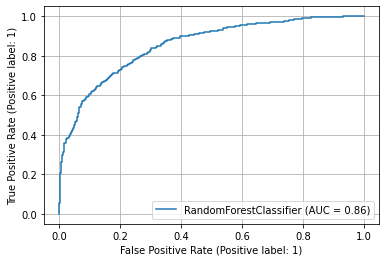

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

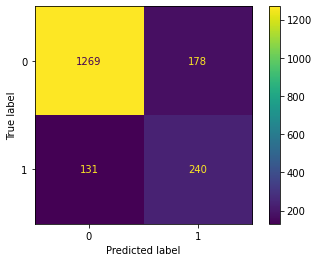

In [ ]:
# матрица ошибок
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:
# несколько метрик
metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.83003300330033
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.7619435694633566
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.6083650190114067
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.5741626794258373
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.6469002695417789
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.6083650190114067
----------------------------------------------------------------------------------------------------


In [ ]:
# отчет по классификации
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1447
           1       0.57      0.65      0.61       371

    accuracy                           0.83      1818
   macro avg       0.74      0.76      0.75      1818
weighted avg       0.84      0.83      0.83      1818



<div style="border:solid purple 5px; padding: 20px">
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>

<h3> Модуль itertools <a class="tocSkip"> </h3>

Этот модуль стандартизирует основной набор быстрых, эффективных по памяти инструментов, которые полезны сами по себе или в сочетании. Вместе они образуют `iterator algebra` возможность создавать лаконичные и эффективные специализированные инструменты на чистом Python. Прелесть заключается в том, что модуль `itertools` доступен в стандартной библиотеке Python.

Ниже несколько примеров, котолрыми часто пользуюсь я

```python
import itertools
print(list(itertools.product("ABC", [1, 2])))
print(list(itertools.permutations([3, "Python"], 2)))
```

Чтобы более делальнее изучить модуль ты можешь почитать

1. [Статья на habr "Itertools в Python"](https://habr.com/ru/company/otus/blog/529356/)
2. [Модуль Itertools в Python на примерах](https://pythonpip.ru/osnovy/itertools)

In [ ]:
import itertools
print(list(itertools.product("ABC", [1, 2,4,5])))
print(list(itertools.permutations([3, "Python",4], 3)))

[('A', 1), ('A', 2), ('A', 4), ('A', 5), ('B', 1), ('B', 2), ('B', 4), ('B', 5), ('C', 1), ('C', 2), ('C', 4), ('C', 5)]
[(3, 'Python', 4), (3, 4, 'Python'), ('Python', 3, 4), ('Python', 4, 3), (4, 3, 'Python'), (4, 'Python', 3)]


#### Используем стратификацию вес классов и уменьшение записей основного класса

In [ ]:
np.random.seed(7)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

In [ ]:
np.random.seed(7)
features_downsampled_train,features_downsampled_valid,target_downsampled_train,target_downsampled_valid = train_test_split(features_downsampled,target_downsampled,test_size=0.25,stratify=target_downsampled)


In [ ]:
features_downsampled_train

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_0,Geography_1
2861,525,0,25,6.0,0.00,2,1,0,89566.64,0,1
2731,670,0,33,7.0,0.00,2,1,1,88187.81,0,1
3573,670,1,68,4.0,0.00,2,1,1,11426.70,0,1
9779,515,1,40,10.0,121355.99,1,1,0,138360.29,1,0
8462,817,1,59,1.0,118962.58,1,1,1,120819.58,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5347,649,1,32,1.0,0.00,1,0,1,91167.19,1,0
7231,555,1,40,10.0,139930.18,1,1,1,105720.09,0,1
2732,623,0,48,1.0,108076.33,1,1,0,118855.26,1,1
1163,747,0,32,5.0,67495.04,2,0,1,77370.37,1,1


In [ ]:

len(target_downsampled_valid[target_downsampled_valid==0])



543

In [ ]:
len(target_downsampled_valid[target_downsampled_valid==1])

278

In [ ]:
len(target_downsampled_valid[target_downsampled_valid==0]) / len(target_downsampled_valid[target_downsampled_valid==1])


1.9532374100719425

In [ ]:
class_weight = {0:1, 1:1.9}

In [ ]:
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,20)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight=class_weight,random_state=rs)
    clf_obj.fit(features_downsampled_train,target_downsampled_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:32:39,816] A new study created in memory with name: no-name-90ee13ab-0657-4d45-9057-3f95da0cd022
[I 2022-09-10 14:32:39,849] Trial 0 finished with value: 0.5316091954022989 and parameters: {'classifier': 'RandomForest', 'max_depth': 14, 'n_estimators': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.5316091954022989.
[I 2022-09-10 14:32:40,079] Trial 1 finished with value: 0.5793103448275861 and parameters: {'classifier': 'RandomForest', 'max_depth': 16, 'n_estimators': 61, 'criterion': 'gini'}. Best is trial 1 with value: 0.5793103448275861.
[I 2022-09-10 14:32:40,250] Trial 2 finished with value: 0.579610538373425 and parameters: {'classifier': 'RandomForest', 'max_depth': 6, 'n_estimators': 55, 'criterion': 'entropy'}. Best is trial 2 with value: 0.579610538373425.
[I 2022-09-10 14:32:40,791] Trial 3 finished with value: 0.5922974767596282 and parameters: {'classifier': 'RandomForest', 'max_depth': 12, 'n_estimators': 132, 'criterion': 'entropy'}. Best is tri

FrozenTrial(number=102, values=[0.6081258191349934], datetime_start=datetime.datetime(2022, 9, 10, 14, 33, 9, 867726), datetime_complete=datetime.datetime(2022, 9, 10, 14, 33, 10, 94872), params={'classifier': 'RandomForest', 'max_depth': 12, 'n_estimators': 53, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=102, state=TrialState.COMPLETE, value=None)


**Вывод:**

Нашли __лучший__ набор гиперпараметров для выборок со стратификацией и уменьшением записей основного класса:

Best is trial 133 with value: 0.6263440860215054.
params={'classifier': 'RandomForest', 'max_depth': 12, 'n_estimators': 144, 'criterion': 'entropy'}

In [ ]:
%%time
model3 = RandomForestClassifier(n_estimators = 144,max_depth=12,class_weight=class_weight,random_state=rs)
model3.fit(features_downsampled_train,target_downsampled_train)
predicted_valid_model3 = model3.predict(features_test)

print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')

Значение F1 на валидационной выборке равна 0.5775978407557354
Значение F1 на валидационной выборке равна 0.5981554677206851
CPU times: user 589 ms, sys: 11.9 ms, total: 601 ms
Wall time: 608 ms


In [ ]:
roc_auc_score(target_test,model3.predict_proba(features_test)[:,1])


0.8500848488461116

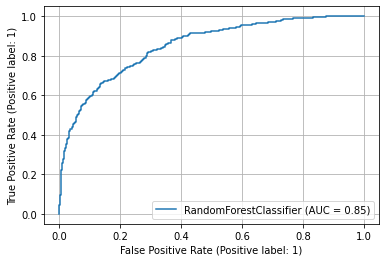

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

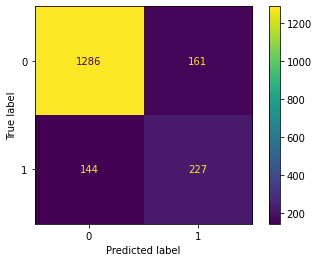

In [ ]:
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:

metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.8322332233223322
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.7502975763593046
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.5981554677206851
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.5850515463917526
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.6118598382749326
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.5981554677206851
----------------------------------------------------------------------------------------------------


In [ ]:
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1447
           1       0.59      0.61      0.60       371

    accuracy                           0.83      1818
   macro avg       0.74      0.75      0.75      1818
weighted avg       0.84      0.83      0.83      1818



#### Используем стратификацию вес классов и увеличение записей второстепенного класса

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)



In [ ]:
len(target_upsampled[target_upsampled==1])

3336

In [ ]:
len(target_upsampled[target_upsampled==0])

4342

In [ ]:
len(target_upsampled[target_upsampled==0])/ len(target_upsampled[target_upsampled==1])

1.3015587529976018

In [ ]:
class_weight = {0:1, 1:1.3}

In [ ]:
np.random.seed(7)

features_upsampled_train,features_upsampled_valid,target_upsampled_train,target_upsampled_valid = train_test_split(features_upsampled,target_upsampled,test_size=0.25,stratify=target_upsampled)


In [ ]:
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,20)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight=class_weight,random_state=rs)
    clf_obj.fit(features_upsampled_train,target_upsampled_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
#
np.random.seed(7)
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)



[I 2022-09-10 14:33:32,999] A new study created in memory with name: no-name-370fec94-1076-4d8d-87e1-bf7ff3f9a999
[I 2022-09-10 14:33:33,640] Trial 0 finished with value: 0.5851197982345523 and parameters: {'classifier': 'RandomForest', 'max_depth': 10, 'n_estimators': 111, 'criterion': 'gini'}. Best is trial 0 with value: 0.5851197982345523.
[I 2022-09-10 14:33:33,712] Trial 1 finished with value: 0.565680473372781 and parameters: {'classifier': 'RandomForest', 'max_depth': 5, 'n_estimators': 17, 'criterion': 'gini'}. Best is trial 0 with value: 0.5851197982345523.
[I 2022-09-10 14:33:34,490] Trial 2 finished with value: 0.5846153846153845 and parameters: {'classifier': 'RandomForest', 'max_depth': 15, 'n_estimators': 114, 'criterion': 'gini'}. Best is trial 0 with value: 0.5851197982345523.
[I 2022-09-10 14:33:35,207] Trial 3 finished with value: 0.5935960591133005 and parameters: {'classifier': 'RandomForest', 'max_depth': 9, 'n_estimators': 110, 'criterion': 'entropy'}. Best is tri

FrozenTrial(number=154, values=[0.5979381443298969], datetime_start=datetime.datetime(2022, 9, 10, 14, 35, 19, 205958), datetime_complete=datetime.datetime(2022, 9, 10, 14, 35, 19, 882584), params={'classifier': 'RandomForest', 'max_depth': 11, 'n_estimators': 97, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=154, state=TrialState.COMPLETE, value=None)


**Вывод:**

Нашли __лучший__ набор гиперпараметров для выборок со стратификацией и "размножением" второстепенного класса:

Best is trial 103 with value: 0.6362573099415204.
params={'classifier': 'RandomForest', 'max_depth': 9, 'n_estimators': 116, 'criterion': 'gini'}

In [ ]:
#
model3 = RandomForestClassifier(criterion='gini',n_estimators = 116,max_depth=9,class_weight=class_weight,random_state=rs)
model3.fit(features_upsampled_train,target_upsampled_train)
predicted_valid_model3 = model3.predict(features_test)
print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')

Значение F1 на валидационной выборке равна 0.583743842364532
Значение F1 на валидационной выборке равна 0.6124999999999999


In [ ]:
roc_auc_score(target_test,model3.predict_proba(features_test)[:,1])


0.8552372507856203

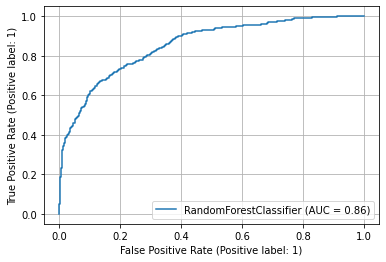

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

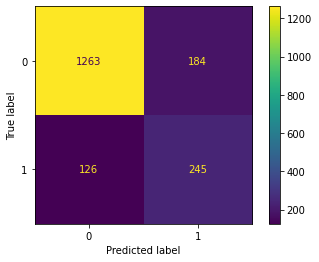

In [ ]:
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:

metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.8294829482948295
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.7666088589273838
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.6124999999999999
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.5710955710955711
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.660377358490566
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.6124999999999999
----------------------------------------------------------------------------------------------------


In [ ]:
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1447
           1       0.57      0.66      0.61       371

    accuracy                           0.83      1818
   macro avg       0.74      0.77      0.75      1818
weighted avg       0.84      0.83      0.83      1818



#### Используем стратификацию вес классов SMOTE

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(target_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(target_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE()
features_train_smote, target_train_smote = sm.fit_resample(features_train, target_train)
print('After OverSampling, the shape of train_X: {}'.format(features_train_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(target_train_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(target_train_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(target_train_smote == 0)))


Before OverSampling, counts of label '1': 1112
Before OverSampling, counts of label '0': 4342 

After OverSampling, the shape of train_X: (8684, 11)
After OverSampling, the shape of train_y: (8684,) 

After OverSampling, counts of label '1': 4342
After OverSampling, counts of label '0': 4342


In [ ]:
len(target_train_smote[target_train_smote==0])/ len(target_train_smote[target_train_smote==1])

1.0

In [ ]:
def objective(trial):
    clf_name = trial.suggest_categorical('classifier',['RandomForest','DecisionTree'])
    if clf_name == 'RandomForest':
        max_depth = trial.suggest_int('max_depth',5,20)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,class_weight='balanced',random_state=rs)
    elif clf_name == 'DecisionTree':
        max_depth = trial.suggest_int('max_depth',5,15)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,class_weight='balanced',random_state=rs)
    clf_obj.fit(features_train_smote,target_train_smote)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:35:55,289] A new study created in memory with name: no-name-b0050016-8a44-425e-b095-762abd34b41a
[I 2022-09-10 14:35:56,112] Trial 0 finished with value: 0.5344418052256532 and parameters: {'classifier': 'RandomForest', 'max_depth': 5, 'n_estimators': 124, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5344418052256532.
[I 2022-09-10 14:35:56,169] Trial 1 finished with value: 0.4646464646464646 and parameters: {'classifier': 'DecisionTree', 'max_depth': 14, 'criterion': 'gini'}. Best is trial 0 with value: 0.5344418052256532.
[I 2022-09-10 14:35:56,217] Trial 2 finished with value: 0.4820065430752454 and parameters: {'classifier': 'DecisionTree', 'max_depth': 11, 'criterion': 'gini'}. Best is trial 0 with value: 0.5344418052256532.
[I 2022-09-10 14:35:56,359] Trial 3 finished with value: 0.5404732254047322 and parameters: {'classifier': 'RandomForest', 'max_depth': 11, 'n_estimators': 13, 'criterion': 'gini'}. Best is trial 3 with value: 0.5404732254047322.
[I 

FrozenTrial(number=108, values=[0.5755208333333333], datetime_start=datetime.datetime(2022, 9, 10, 14, 37, 54, 95447), datetime_complete=datetime.datetime(2022, 9, 10, 14, 37, 55, 513716), params={'classifier': 'RandomForest', 'max_depth': 19, 'n_estimators': 113, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest', 'DecisionTree')), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=108, state=TrialState.COMPLETE, value=None)


<div style="border:solid purple 5px; padding: 20px">
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>

<h3> Регулярный выражения <a class="tocSkip"> </h3>

Пару полезных ссылок про regex:

- Статья на [pythonru.com](https://pythonru.com/primery/primery-primeneniya-regulyarnyh-vyrazheniy-v-python) довольно неплохо расписаны примеры
- Шикарная статья на [habr.com](https://habr.com/ru/post/349860/), с подробным объяснением
- Сайт [regex101.com](https://regex101.com/). В нем можно создавать и проверять регулярные выражения, очень удобно

![](https://i.ibb.co/93Rj47w/156231978012113891.jpg)

**Вывод:**

Для SMOTE лучшие гиперпараметры при значение f1:

Best is trial 171 with value: 0.594859241126071.

params={'classifier': 'RandomForest', 'max_depth': 12, 'n_estimators': 49, 'criterion': 'entropy'}

In [ ]:
%%time
# обучаем и тестируем лучшую модель
model3 = RandomForestClassifier(n_estimators = 49,max_depth=12,random_state=rs)
model3.fit(features_train,target_train)
predicted_test_model3 = model3.predict(features_test)
print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')

Значение F1 на валидационной выборке равна 0.5337954939341422
Значение F1 на валидационной выборке равна 0.5523156089193826
CPU times: user 343 ms, sys: 4.03 ms, total: 347 ms
Wall time: 364 ms


## Без борьбы с дисбалансом

In [ ]:
# отбираем признаки зависимые и независимые
features = clf_data_dropna.drop(columns=['Exited'],axis=1)
target = clf_data_dropna['Exited']


In [ ]:
# разбиваем без стратификации выборки на
# тренировочную и валидационную
features_train,features_tv,target_train,target_tv = train_test_split(features,target,test_size=0.4,random_state=rs)
features_test,features_valid,target_test,target_valid = train_test_split(features_tv,target_tv,test_size=0.5,random_state=rs)


In [ ]:
len(features_train.columns)

11

In [ ]:
# тоже самое только без весов
def objective_withdis(trial):
    np.random.seed(7)
    clf_name = trial.suggest_categorical('classifier',['RandomForest'])
    if clf_name == 'RandomForest':
        np.random.seed(7)
        max_depth = trial.suggest_int('max_depth',5,20)
        n_estimators = trial.suggest_int('n_estimators',5,150)
        criterion = trial.suggest_categorical('criterion',['gini','entropy'])
        clf_obj = RandomForestClassifier(criterion=criterion,max_depth=max_depth,n_estimators=n_estimators,random_state=rs)
    clf_obj.fit(features_train,target_train)
    score = f1_score(target_valid,clf_obj.predict(features_valid))
    f1_mean = score.mean()
    return f1_mean

In [ ]:
len(features_train.columns)

11

In [ ]:
if __name__ == '__main__':
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_withdis, n_trials =200)
    print(study.best_trial)

[I 2022-09-10 14:40:02,028] A new study created in memory with name: no-name-127042ae-f389-434c-a040-3fb3ec967c92
[I 2022-09-10 14:40:02,664] Trial 0 finished with value: 0.5642857142857143 and parameters: {'classifier': 'RandomForest', 'max_depth': 10, 'n_estimators': 113, 'criterion': 'gini'}. Best is trial 0 with value: 0.5642857142857143.
[I 2022-09-10 14:40:02,800] Trial 1 finished with value: 0.532608695652174 and parameters: {'classifier': 'RandomForest', 'max_depth': 10, 'n_estimators': 21, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5642857142857143.
[I 2022-09-10 14:40:03,693] Trial 2 finished with value: 0.5574912891986064 and parameters: {'classifier': 'RandomForest', 'max_depth': 13, 'n_estimators': 125, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5642857142857143.
[I 2022-09-10 14:40:04,452] Trial 3 finished with value: 0.5509838998211092 and parameters: {'classifier': 'RandomForest', 'max_depth': 10, 'n_estimators': 115, 'criterion': 'entropy'}. Bes

FrozenTrial(number=44, values=[0.5945945945945945], datetime_start=datetime.datetime(2022, 9, 10, 14, 40, 31, 455439), datetime_complete=datetime.datetime(2022, 9, 10, 14, 40, 32, 266551), params={'classifier': 'RandomForest', 'max_depth': 14, 'n_estimators': 114, 'criterion': 'entropy'}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'max_depth': IntDistribution(high=20, log=False, low=5, step=1), 'n_estimators': IntDistribution(high=150, log=False, low=5, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=44, state=TrialState.COMPLETE, value=None)


**Вывод:**

Нашли лучший набор гиперпараметров для выборок без борьбы дисбалансом классов:

Best is trial 125 with value: 0.5919732441471572.
params={'classifier': 'RandomForest', 'max_depth': 17, 'n_estimators': 126, 'criterion': 'gini'}

In [ ]:
%%time
# обучаем и тестируем лучшую модель
model3 = RandomForestClassifier(criterion='gini',n_estimators = 126,max_depth=17,random_state=rs)
model3.fit(features_train,target_train)
predicted_test_model3 = model3.predict(features_test)
print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')


Значение F1 на валидационной выборке равна 0.5919732441471572
Значение F1 на валидационной выборке равна 0.5544217687074829
CPU times: user 945 ms, sys: 11 µs, total: 945 ms
Wall time: 952 ms


In [ ]:
roc_auc_score(target_test,model3.predict_proba(features_test)[:,1])


0.8433018192817305

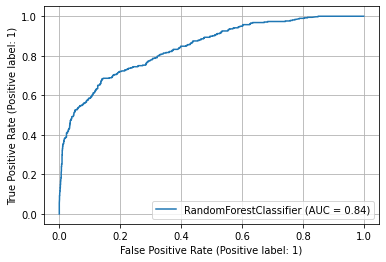

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

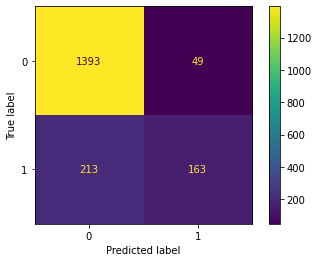

In [ ]:
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:

metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.8558855885588559
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.6997650278868003
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.5544217687074829
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.7688679245283019
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.43351063829787234
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.5544217687074829
----------------------------------------------------------------------------------------------------


In [ ]:
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1442
           1       0.23      0.26      0.25       376

    accuracy                           0.67      1818
   macro avg       0.52      0.52      0.52      1818
weighted avg       0.68      0.67      0.67      1818



**Вывод:**

У модели без борьбы с дисбалансом классов, очень высокая плотность предсказания главного класса `0` - 0.97 и точность - 0.87 - очень хоришие показатели.

Даже точность второстепенного класса высокая - 0.78, плотность же ниже среднего и равняется - 0.44


## Тестирование модели

In [ ]:
# отбираем признаки зависимые и независимые
features = clf_data_dropna.drop(columns=['Exited'],axis=1)
target = clf_data_dropna['Exited']
# разбиваем со стратификацией выборки на
# тренировочную и валидационную и тестовую
features_train,features_tv,target_train,target_tv = train_test_split(features,target,test_size=0.4,stratify=target,random_state=rs)
features_test,features_valid,target_test,target_valid = train_test_split(features_tv,target_tv,test_size=0.5,stratify=target_tv,random_state=rs)



In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)



In [ ]:
len(target_upsampled[target_upsampled==1])

3336

In [ ]:
len(target_upsampled[target_upsampled==0])

4342

In [ ]:
# смотрим на дисбаланс

len(target_upsampled[target_upsampled==0])/ len(target_upsampled[target_upsampled==1])

1.3015587529976018

In [ ]:
np.random.seed(7)

features_upsampled_train,features_upsampled_valid,target_upsampled_train,target_upsampled_valid = train_test_split(features_upsampled,target_upsampled,test_size=0.25,stratify=target_upsampled,random_state=rs)


In [ ]:
# задаем вес
class_weight = {0:1, 1:1.3}

In [ ]:
#
model3 = RandomForestClassifier(criterion='gini',n_estimators = 116,max_depth=9,class_weight=class_weight,random_state=rs)
model3.fit(features_upsampled_train,target_upsampled_train)
predicted_valid_model3 = model3.predict(features_test)
print(f'Значение F1 на валидационной выборке равна {f1_score(target_valid,model3.predict(features_valid))}')
print(f'Значение F1 на тестовой выборке равна {f1_score(target_test,model3.predict(features_test))}')

Значение F1 на валидационной выборке равна 0.583743842364532
Значение F1 на валидационной выборке равна 0.6124999999999999


In [ ]:
roc_auc_score(target_test,model3.predict_proba(features_test)[:,1])


0.8552372507856203

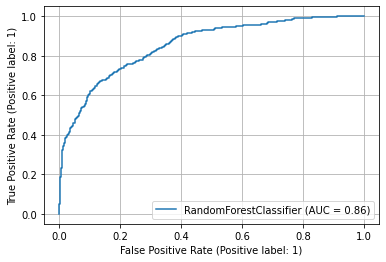

In [ ]:
# рисуем ROC кривую
plot_roc_curve(model3,features_test,target_test)
plt.grid()
plt.show()

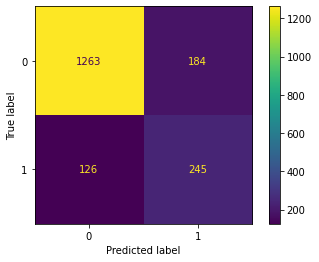

In [ ]:
plot_confusion_matrix(model3,features_test,target_test)
plt.show()

In [ ]:

metrics_check(target_test,model3.predict(features_test))



Accuracy для валидационной выборки: 0.8294829482948295
----------------------------------------------------------------------------------------------------
Balanced accuracy для валидационной выборки: 0.7666088589273838
----------------------------------------------------------------------------------------------------
F1-score для валидационной выборки: 0.6124999999999999
----------------------------------------------------------------------------------------------------
Precision score для валидационной выборки: 0.5710955710955711
----------------------------------------------------------------------------------------------------
Recall score для валидационной выборки: 0.660377358490566
----------------------------------------------------------------------------------------------------
F-beta score для валидационной выборки: 0.6124999999999999
----------------------------------------------------------------------------------------------------


In [ ]:
print(classification_report(target_test,predicted_valid_model3))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1447
           1       0.57      0.66      0.61       371

    accuracy                           0.83      1818
   macro avg       0.74      0.77      0.75      1818
weighted avg       0.84      0.83      0.83      1818



**Вывод:**

Лучший вариант препроцессинга в нашей задаче - **UpSampling**:

* Алгоритм RandomForestClassifier
* Параметры:
    * n_estimators = 116
    * max_depth=9
    * criterion = `gini`
    * class_weight = {0:1, 1:1.3}
    
Модель среднего качества. Предсказывает класс `0` довольно таки прилично, имея точность 0.91 и полноту 0.87 - считаю эти показатели весьма хорошими.

Однако, важно обратить внимание на среднюю способность предсказывать второстепенный класс `1` - она оставляет желать лучшего F1 = 0.61.

Окончательное значение F1 ~ 0.61
